In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
plt.rc('figure', facecolor='w')
plt.rc('font', size=11)

In [2]:
def read_pmf(filename):
    return np.loadtxt(filename).T[:2]

string = np.loadtxt('data/PTP1B.string').T
full_pmf = read_pmf('data/PTP1B_pmf.dat')
split_pmf = np.array([read_pmf(f'data/PTP1B_split_pmf/{i}.dat') for i in range(1, 6)])
react_idx = np.argmin(full_pmf[1])
split_pmf[:,1,:] = split_pmf[:,1,:] - split_pmf[:,1,react_idx][:,None]
err = np.std(split_pmf[:,1,:], axis=0)
rms = np.loadtxt('data/PTP1B_rms.dat').T

In [3]:
rms_node_closed = rms[1::2]
rms_node_open = rms[2::2]

In [4]:
s = np.array([np.loadtxt(f'data/s_PTP1B/{i+1}.dat')[:,0] for i in range(60)])

In [5]:
y, x = np.histogram(s, bins=50, range=(np.min(s), np.max(s)+1E-6))
bin_centers = (x[1:] + x[:-1]) / 2
nbins = len(y)
bin_width = x[1] - x[0]
bin_idx = ((s - x[0]) // bin_width).astype(int)
counts = np.array([np.sum(bin_idx == i) for  i in range(len(x)-1)])

In [6]:
def mean_by_bins(data, bin_idx):
    return np.array([np.mean(data[bin_idx == i]) 
                     for i in range(np.max(bin_idx) +1)])

def std_by_bins(data, bin_idx):
    return np.array([np.std(data[bin_idx == i]) 
                     for i in range(np.max(bin_idx) + 1)])
    
mean_rms_closed = mean_by_bins(rms_node_closed, bin_idx)
std_rms_closed = std_by_bins(rms_node_closed, bin_idx)
mean_rms_open = mean_by_bins(rms_node_open, bin_idx)
std_rms_open = std_by_bins(rms_node_open, bin_idx)

In [7]:
def plot_a(ax):
    ax.set_xlabel('s (a.m.u.$^{1/2}\cdot\AA$)')
    ax.set_ylabel('PMF (kcal/mol)')
    ax.plot(full_pmf[0], full_pmf[1], c='navy')
    ax.fill_between(full_pmf[0],  full_pmf[1] - err, 
                    full_pmf[1] + err,
                    facecolor='blue',
                    alpha=0.2)

In [8]:
def plot_b(ax):
    ax.set_xlabel('s (a.m.u.$^{1/2}\cdot\AA$)')
    ax.set_ylabel('RMSD ($\AA$)')
    ax.set_ylim(0.4, 2.45)
    x = bin_centers
    ax.plot(x, mean_rms_closed, label='closed', c='blue')
    ax.plot(x, mean_rms_open, label='open', c='red')    
    ax.fill_between(x, 
                    mean_rms_closed - std_rms_closed, 
                    mean_rms_closed + std_rms_closed,
                    facecolor='blue',
                    alpha=0.2)
    ax.fill_between(x, 
                    mean_rms_open - std_rms_open, 
                    mean_rms_open + std_rms_open,
                    facecolor='red',
                    alpha=0.2)
    ax.legend()

In [9]:
from matplotlib.patches import Ellipse
from matplotlib.legend_handler import HandlerTuple

def plot_c(ax):
    ax.set_xlabel('$d_1 - d_2$ ($\AA$)')
    ax.set_ylabel('$\Psi_{181} - \Phi_{182}$ ($\degree$)')
    ts = string[:,19] * 0.75 + string[:,18] * 0.25
    ax.plot(string[1] - string[2], string[3]-string[4], c='navy')
    ts_patch = Ellipse((ts[1]-ts[2], ts[3]-ts[4]), 0.75, 30, fc='orange', ec="black", zorder=100)
    ax.add_patch(ts_patch)
    
    circle = plt.Line2D([], [], marker='o', color='orange', markeredgecolor='black', markersize=10, linestyle='None', label='TS')
    ax.legend(handles=[circle], loc='lower right')

In [10]:
def plot_d(ax1):
    ax1.set_xlabel('s (a.m.u.$^{1/2}\cdot\AA$)')
    ax1.set_xlim(-3, 42)
    ax1.set_ylabel('Angle ($\degree$)', labelpad=-5)
    ax1.set_ylim(-240,360)
    ax2 = ax1.twinx()
    ax2.set_ylabel('Distance ($\AA$)')
    ax2.set_ylim(1.5,14.5)
    x = string[0]

    colors = ('blue', 'red', 'green', 'orange')
    labels = ('$\Psi_{181}$', 
              '$\Phi_{182}$',
              '$d_1$', 
              '$d_2$')
    for y, c in zip(string[3:5], colors[2:]):
        ax1.plot(x, y, c=c)    
    for y, c in zip(string[1:3], colors[:2]):
        ax2.plot(x, y, c=c, linestyle='dashed')    

    ax1.legend(ax1.lines + ax2.lines, labels, loc='lower center', 
               ncol=4, columnspacing=0.5, handletextpad=0.4, )

ValueError: operands could not be broadcast together with shapes (200,) (300,) 

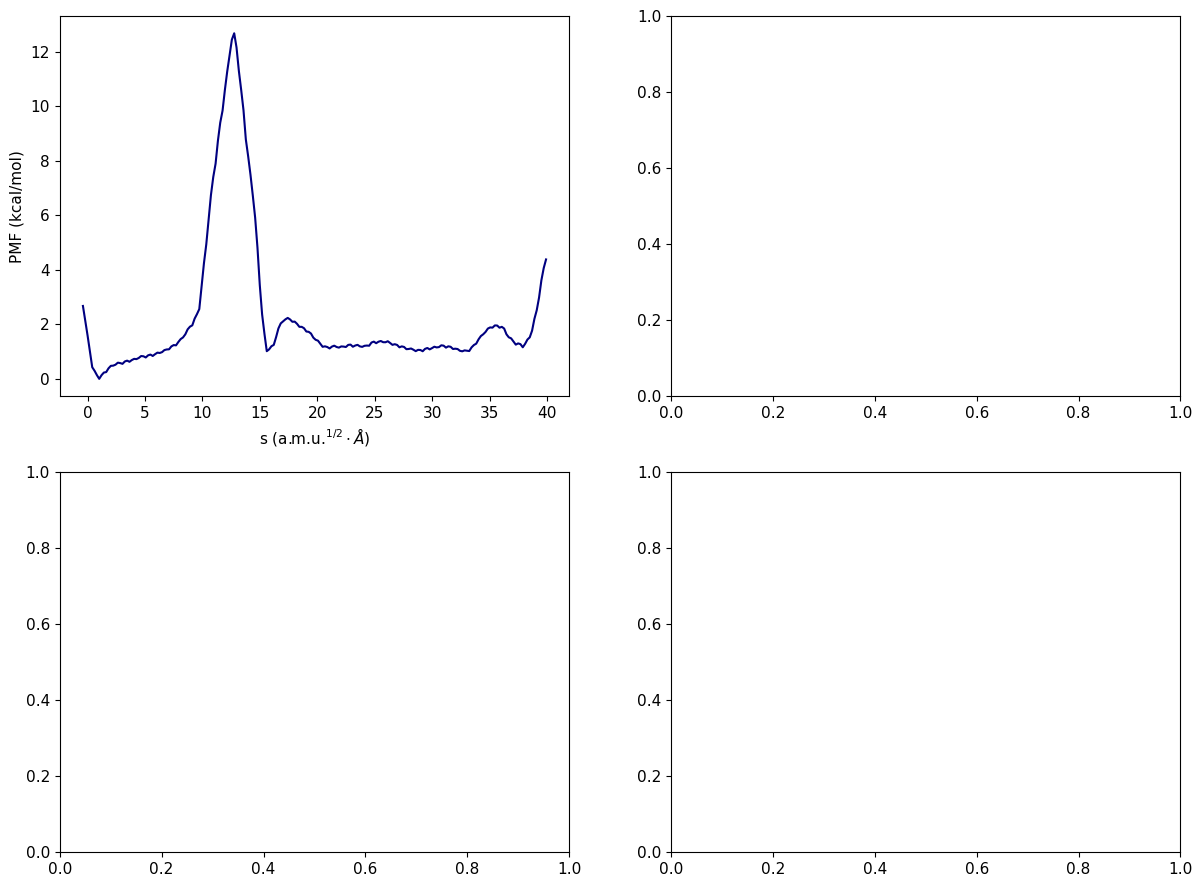

In [11]:
fig, axs = plt.subplot_mosaic([['a', 'b'], ['c', 'd']], figsize=(12,9))
fig.tight_layout()
plt.subplots_adjust(hspace=0.2, wspace=0.2)
plot_a(axs['a'])
plot_b(axs['b'])
plot_c(axs['c'])
plot_d(axs['d'])

for label, ax in axs.items():
    trans = mtransforms.ScaledTranslation(10/72, -5/72, fig.dpi_scale_trans)
    ax.text(-0.01, 1.0, label, transform=ax.transAxes + trans,
            verticalalignment='top', fontsize='large')

plt.savefig('Fig3.png', dpi=300, bbox_inches='tight')
plt.show()